<a href="https://colab.research.google.com/github/khoji-code/Data-Science-AI-for-Business-Portfolio/blob/main/Projects/Predictive_Maintenance_for_NASA_Turbofan_Engines_using_Bi_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Maintenance for NASA Turbofan Engines using Bi-LSTM

***

### **Project Overview**

* **Goal:** To develop a deep learning model to accurately predict the Remaining Useful Life (RUL) of turbofan engines based on time-series sensor data.
* **Dataset:** Utilizes the C-MAPSS (Commercial Modular Aero-Propulsion System Simulation) dataset from NASA, specifically the FD001 subset.
* **Methodology:** The project involves a comprehensive data preprocessing pipeline, including the calculation and capping of RUL, feature scaling, and the creation of time-series sequences. A Bidirectional Long Short-Term Memory (Bi-LSTM) network is built and trained using TensorFlow and Keras to learn temporal patterns from the sensor data.
* **Key Results:** The model demonstrates strong predictive performance on the test set, achieving a Root Mean Squared Error (RMSE) of **16.46** and an R-squared (R2) score of **0.84**, indicating its effectiveness in forecasting engine degradation.

***

### **Purpose**

* **Preventative Maintenance:** To create a reliable predictive model that can help airlines and maintenance crews anticipate engine failures, enabling them to perform maintenance proactively rather than reactively. This significantly improves safety and reduces the risk of in-flight failures.
* **Optimize Maintenance Schedules:** To provide data-driven insights that can be used to optimize maintenance schedules, reducing unnecessary maintenance costs and minimizing aircraft downtime. By accurately predicting the RUL, maintenance can be scheduled just-in-time.
* **Increase Operational Efficiency:** To enhance the overall operational efficiency of the airline fleet by improving the reliability of the engines and reducing the likelihood of unexpected maintenance events.

### Dataset:
https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data

## SETUP AND CONFIGURATION

In [ ]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.optimizers import Adam
import warnings

# Explain: Ignore warnings for a cleaner output.
warnings.filterwarnings('ignore')

# Configure which dataset to use (FD001, FD002, FD003, or FD004)
DATASET_NAME = 'FD001'
SEQUENCE_LENGTH = 50 # Number of time steps to look back
RUL_CAP = 125 # Cap the RUL values to focus on the critical period before failure

# --- 1. EXTRACT DATA FROM LOCAL ZIP FILE ---
print("--- Step 1: Extracting Data from Local Zip File ---")
# Set the path to the zip file you uploaded to Colab
zip_path = '/content/drive/MyDrive/NASA/CMAPSSData.zip'
!ls /content/
extract_path = 'c-mapss-data/'

# Check if the zip file exists before trying to extract
if os.path.exists(zip_path):
    # Check if the extraction directory exists, if not, create it and extract
    if not os.path.exists(extract_path):
        print(f"Extracting data from {zip_path}...")
        with ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Data extracted successfully.")
    else:
        print(f"Data directory '{extract_path}' already exists. Skipping extraction.")
else:
    print(f"ERROR: The file '{zip_path}' was not found.")
    print("Please make sure you have uploaded the file to your Colab session.")

--- Step 1: Extracting Data from Local Zip File ---
c-mapss-data  drive  sample_data
Data directory 'c-mapss-data/' already exists. Skipping extraction.


## LOAD DATA

In [ ]:
# Column Names
column_names = ['unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
               [f'sensor_{i}' for i in range(1, 22)]
# Define file paths
train_file = os.path.join(extract_path, f'train_{DATASET_NAME}.txt')
test_file = os.path.join(extract_path, f'test_{DATASET_NAME}.txt')
rul_file = os.path.join(extract_path, f'RUL_{DATASET_NAME}.txt')

# Load the data, checking if files exist first
if os.path.exists(train_file) and os.path.exists(test_file) and os.path.exists(rul_file):
    train_df = pd.read_csv(train_file, sep='\s+', header=None, names=column_names)
    test_df = pd.read_csv(test_file, sep='\s+', header=None, names=column_names)
    rul_df = pd.read_csv(rul_file, sep='\s+', header=None, names=['RUL'])
    if rul_df.shape[1] > 1:
        rul_df = rul_df.drop(columns=[1])

    print(f"Training data shape: {train_df.shape}")
    print(f"Test data shape: {test_df.shape}")
    print(f"RUL data shape: {rul_df.shape}")
    print("Data Loaded")
else:
    print("ERROR: Could not find the required .txt files in the extracted folder.")
    print("Please check the contents of the zip file.")


Training data shape: (20631, 26)
Test data shape: (13096, 26)
RUL data shape: (100, 1)
Data Loaded


## DATA PREPROCESSING

In [ ]:
# Identify and drop columns with constant values (useless sensors)
constant_cols = [col for col in train_df.columns if train_df[col].std() == 0]
print(f"Dropping constant sensor columns: {constant_cols}")
train_df = train_df.drop(columns=constant_cols)
test_df = test_df.drop(columns=constant_cols)

# Define the feature columns to be used for training
feature_cols = [col for col in train_df.columns if col.startswith(('op_setting', 'sensor'))]
print(f"Number of features being used: {len(feature_cols)}")

# Calculate and clip RUL for the training data
max_cycles = train_df.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycles.columns = ['unit_number', 'max_cycle']
train_df = pd.merge(train_df, max_cycles, on='unit_number', how='left')
train_df['RUL'] = train_df['max_cycle'] - train_df['time_in_cycles']
train_df = train_df.drop(columns=['max_cycle'])
train_df['RUL'] = train_df['RUL'].clip(upper=RUL_CAP)
print(f"RUL calculated and capped at {RUL_CAP} cycles.")

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])
print("Features scaled to a range of [0, 1].")
print("Preprocessing Complete")

Dropping constant sensor columns: ['op_setting_3', 'sensor_18', 'sensor_19']
Number of features being used: 21
RUL calculated and capped at 125 cycles.
Features scaled to a range of [0, 1].
Preprocessing Complete


## FEATURE ENGINEERING: CREATE SEQUENCES

In [ ]:
# Creating Time-Series Sequences
def create_sequences(df, seq_length, features, target='RUL'):
    sequences, labels = [], []
    for unit in df['unit_number'].unique():
        unit_data = df[df['unit_number'] == unit]
        for i in range(len(unit_data) - seq_length + 1):
            seq = unit_data.iloc[i:i + seq_length][features].values
            label = unit_data.iloc[i + seq_length - 1][target]
            sequences.append(seq)
            labels.append(label)
    return np.array(sequences), np.array(labels)

X_train, y_train = create_sequences(train_df, SEQUENCE_LENGTH, feature_cols)
print(f"Training sequences created. Shape: {X_train.shape}")
print(f"Training labels created. Shape: {y_train.shape}")
print("Feature Engineering Complete")

Training sequences created. Shape: (15731, 50, 21)
Training labels created. Shape: (15731,)
Feature Engineering Complete


## BUILD THE BIDIRECTIONAL LSTM MODEL

## Building the Bi-LSTM Model

In [ ]:
n_features = X_train.shape[2]

model = Sequential()
model.add(Bidirectional(LSTM(units=100, return_sequences=True), input_shape=(SEQUENCE_LENGTH, n_features)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()
print("Model Built")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 50, 200)        │        97,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100)            │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,551 (783.40 KB)

 Trainable params: 200,551 (783.40 KB)

 Non-trainable params: 0 (0.00 B)

Model Built


## TRAIN THE MODEL

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=64,
                    validation_split=0.2,
                    verbose=1)


Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 64s 283ms/step - loss: 4719.9834 - val_loss: 1804.4039
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 55s 281ms/step - loss: 1700.5380 - val_loss: 1806.2034
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 58s 295ms/step - loss: 1705.5350 - val_loss: 1806.9406
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 59s 299ms/step - loss: 1705.0728 - val_loss: 1820.5016
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 58s 295ms/step - loss: 1610.8149 - val_loss: 547.2003
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 56s 284ms/step - loss: 500.3505 - val_loss: 586.7499
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 81s 280ms/step - loss: 485.1100 - val_loss: 460.4476
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 56s 287ms/step - loss: 424.6452 - val_loss: 442.2756
Epoch 9/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 60s 305ms/step - loss: 406.2425 - val_loss: 470.5052
Epoch 10/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 55s 281ms/step - loss: 421.0379 - val_loss: 430.0757
Epoch 11/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 87s 305ms/step - lo

## Plot training history

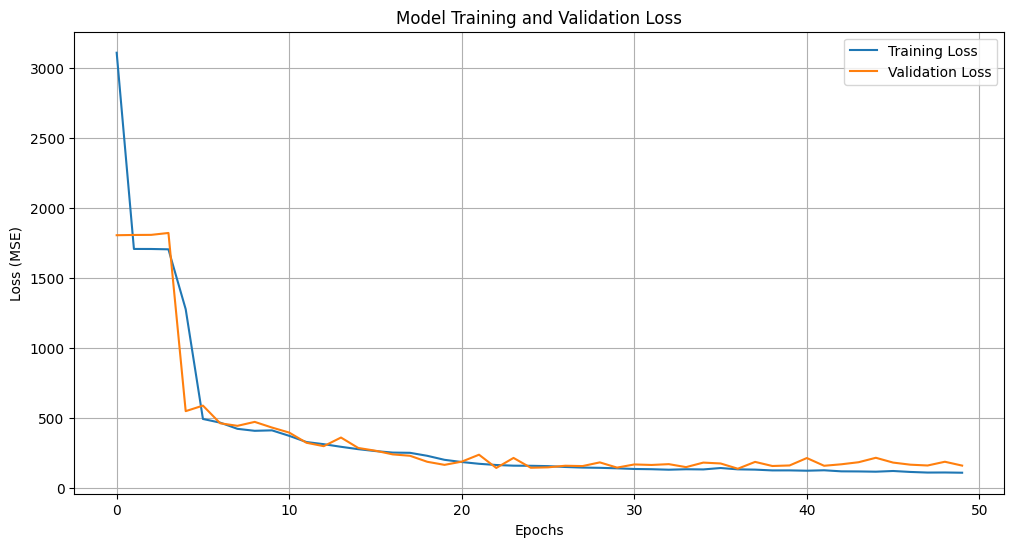

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## EVALUATE THE MODEL

In [ ]:
# Prepare test data sequences
X_test = []
for unit in test_df['unit_number'].unique():
    unit_data = test_df[test_df['unit_number'] == unit]
    last_sequence = unit_data.tail(SEQUENCE_LENGTH)[feature_cols].values
    if last_sequence.shape[0] < SEQUENCE_LENGTH:
        pad_width = ((SEQUENCE_LENGTH - last_sequence.shape[0], 0), (0, 0))
        last_sequence = np.pad(last_sequence, pad_width, 'constant', constant_values=0)
    X_test.append(last_sequence)

X_test = np.array(X_test)
print(f"Test sequences created. Shape: {X_test.shape}")

# Make predictions
y_pred = model.predict(X_test).flatten()
y_true = rul_df['RUL'].values

# Calculate and print evaluation metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
print(f"\n--- Model Evaluation Results for {DATASET_NAME} ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")

Test sequences created. Shape: (100, 50, 21)
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step

--- Model Evaluation Results for FD001 ---
Root Mean Squared Error (RMSE): 16.46
R-squared (R2) Score: 0.84


## Visualize Predictions vs. True Values

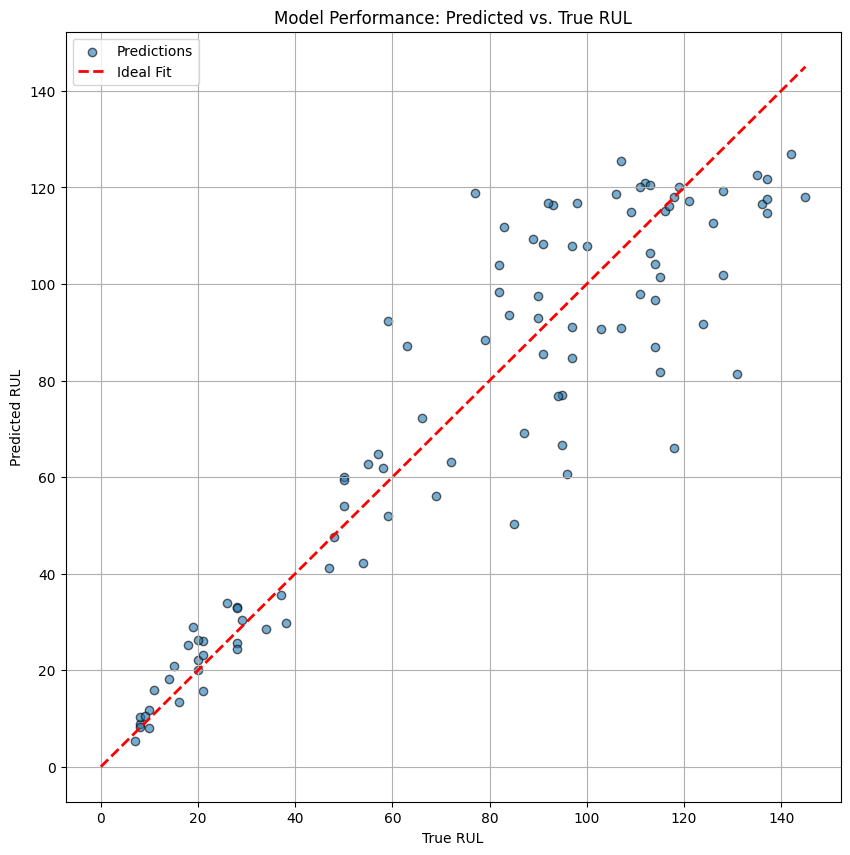

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k', label='Predictions')
plt.plot([0, y_true.max()], [0, y_true.max()], 'r--', lw=2, label='Ideal Fit')
plt.title('Model Performance: Predicted vs. True RUL')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.grid(True)
plt.legend()
plt.show()